# Multi-objective Active Learning Example

---

This notebook demonstrates the computation of Pareto shell errors and the maximum hyperplane probability of improvement (MHPI) acquisition function, both from ["Assessing the Frontier..."](https://aip.scitation.org/doi/full/10.1063/5.0006124) by Z. del Rosario and others.

*Note*: It's my intent to expand this notebook to a full retrospective active learning demo in the future.


## Setup

---


I make use of some standard and not-so-standard libraries in this example. Pandas and numpy are standard; I recommend [Anaconda python](https://www.anaconda.com/products/individual) as a Python distribution that takes care of those core dependencies. You can install packages from the command line via:

> $ pip install py_grama, plotnine, lolopy


In [1]:
import grama as gr
import pandas as pd
import numpy as np
from plotnine import *

DF = gr.Intention()

### Load and wrangle thermoelectric data

You're going to need to install a number of packages to run the following chunk; the following are the libraries necessary to access the Citrination database:

> $ pip install citrination_client, pypif_sdk, pycc

The following libraries are necessary to work with materials data:

> $ pip matminer, pymatgen

### Working with Citrination

Note that the following code accesses the [Citrination](citrination.com) database; you will need to sign up for an account and make your Citrination access key available on your machine. The following code assumes that your machine has your Citrination API key in the environmental variable `CITRINATION_API_KEY`. Here's a [page](https://www.schrodinger.com/kb/1842) describing how to add an environment variable.


In [2]:
from zt_loader import load_data_zT
X_all, Y_all, sign, keys_response, prefix = load_data_zT()


Cached data loaded.


Package the features and responses into a dataframe.


In [3]:
# Package and name the features
df_data_raw = pd.DataFrame(
    data=X_all,
    columns=map(lambda i: "x{}".format(i), range(X_all.shape[1]))
)

# Add the responses
df_data_raw = pd.concat(
    (
        pd.DataFrame(
            data=Y_all,
            columns=keys_response
        ),
        df_data_raw,
    ),
    axis=1
)

# Preview the data
df_data_raw.head()


,Seebeck coefficient; squared,Electrical resistivity,Thermal conductivity,x0,x1,x2,x3,x4,x5,x6,...,x135,x136,x137,x138,x139,x140,x141,x142,x143,x144
0,30276.0000,0.000450,4.016716,2.0,0.721110,0.654213,0.615030,0.604895,0.601032,52.0,...,96.000000,67.200000,152.0,2.000000,3.600000,10.000000,5.600000,1.0,0.001599,0.000384
1,1705.6900,0.000324,2.940000,3.0,0.678467,0.633007,0.620167,0.619161,0.619052,16.0,...,91.238095,48.934240,70.0,2.000000,2.904762,1.904762,2.000000,0.0,0.236926,0.043493
2,6850.8729,0.004128,2.294800,4.0,0.648691,0.609335,0.600536,0.600040,0.600001,8.0,...,97.520000,102.624000,12.0,2.000000,2.800000,2.000000,2.800000,1.0,0.803211,0.142657
3,5867.5600,0.000488,6.160000,3.0,0.744910,0.693131,0.670722,0.667393,0.666730,12.0,...,204.785000,14.765570,194.0,2.000000,0.667667,0.010000,0.014000,0.0,0.118407,0.018546
4,625.0000,0.165000,1.300000,3.0,0.685357,0.622359,0.588314,0.580334,0.577627,16.0,...,57.989613,33.596567,70.0,1.942297,3.403924,3.652626,5.113676,0.0,0.539020,0.040213


The response names are long and unwieldy; let's create some shorter names for convenience:


In [4]:
df_data = df_data_raw.rename(
    {
        "Seebeck coefficient; squared": "y_s2",
        "Electrical resistivity": "y_rho",
        "Thermal conductivity": "y_kappa",
    },
    axis=1,
)
df_data.head()


,y_s2,y_rho,y_kappa,x0,x1,x2,x3,x4,x5,x6,...,x135,x136,x137,x138,x139,x140,x141,x142,x143,x144
0,30276.0000,0.000450,4.016716,2.0,0.721110,0.654213,0.615030,0.604895,0.601032,52.0,...,96.000000,67.200000,152.0,2.000000,3.600000,10.000000,5.600000,1.0,0.001599,0.000384
1,1705.6900,0.000324,2.940000,3.0,0.678467,0.633007,0.620167,0.619161,0.619052,16.0,...,91.238095,48.934240,70.0,2.000000,2.904762,1.904762,2.000000,0.0,0.236926,0.043493
2,6850.8729,0.004128,2.294800,4.0,0.648691,0.609335,0.600536,0.600040,0.600001,8.0,...,97.520000,102.624000,12.0,2.000000,2.800000,2.000000,2.800000,1.0,0.803211,0.142657
3,5867.5600,0.000488,6.160000,3.0,0.744910,0.693131,0.670722,0.667393,0.666730,12.0,...,204.785000,14.765570,194.0,2.000000,0.667667,0.010000,0.014000,0.0,0.118407,0.018546
4,625.0000,0.165000,1.300000,3.0,0.685357,0.622359,0.588314,0.580334,0.577627,16.0,...,57.989613,33.596567,70.0,1.942297,3.403924,3.652626,5.113676,0.0,0.539020,0.040213


### Data Overview

With thermoelectric materials, [efficiency](https://en.wikipedia.org/wiki/Thermoelectric_materials#Thermoelectric_figure_of_merit) is measured in a number of ways. There is not perfect agreement on the "correct" way to measure the merit of a material, so we will take a multi-objective approach to selecting materials. The following table lists the salient material properties and whether we aim to maximize or minimize those quantities:

| Symbol | Quantity | Max/Min |
|---|---|---|
| $S^2$ | Seebeck coefficient; squared | Maximize |
| $\kappa$ | Thermal conductivity | Minimize |
| $\rho$ | Electrical resistivity | Minimize |

Visualizing $\kappa, \rho$ indicates that materials in our database seem to exhibit a tradeoff; we see that materials that tend to have small $\kappa$ tend to have a larger $\rho$, and vice versa.


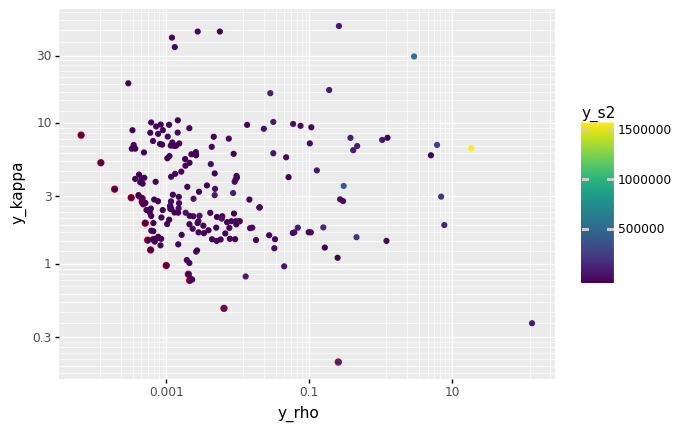

<ggplot: (8730935860718)>

In [5]:
(
    df_data
    >> ggplot(aes("y_rho", "y_kappa", color="y_s2"))
    + geom_point(
        data=df_data
        >> gr.tf_mutate(pareto=gr.pareto_min(DF.y_rho, DF.y_kappa))
        >> gr.tf_filter(DF.pareto),
        color="red",
        size=2,
    )
    + geom_point()
    
    + scale_x_log10()
    + scale_y_log10()
)


Rather than finding "the best" material, we will instead seek to identify a set of materials that represent the best among the tradeoffs we must make. This set is made formal in the [Pareto frontier](https://en.wikipedia.org/wiki/Pareto_efficiency#Pareto_frontier).


## Modeling



In [6]:
var_features = (
    df_data
    >> gr.tf_select(gr.contains("x"))
).columns

out_responses = ["y_rho", "y_kappa", "y_s2"]


In [7]:
from grama.fit import ft_lolo

The following code defines a "model recipe"; fit an independent random forest on each output given the same feature set `var_features`. The `lolo` package implements a random forest with jackknife-after-bootstrap predictive uncertainty estimates.


In [8]:
ft_base = ft_lolo(
    var=var_features,
    out=out_responses,
)


Check the baseline model and training error.


In [9]:
md_base = (
    df_data
    >> ft_base()
)

(
    md_base
    >> gr.ev_df(df=df_data)
    >> gr.tf_summarize(
        ndme_s2=gr.ndme(DF.y_s2_mean, DF.y_s2),
        ndme_kappa=gr.ndme(DF.y_kappa_mean, DF.y_kappa),
        ndme_rho=gr.ndme(DF.y_rho_mean, DF.y_rho),
    )
)


,ndme_s2,ndme_kappa,ndme_rho
0,0.328724,0.312808,0.354789


Training error is somewhat encouraging; NDME values for each objective are below one, indicating a somewhat informative model.


Standard error estimation via k-folds cross validation.


In [10]:
(
    df_data
    >> gr.tf_kfolds(
        ft=ft_base,
        out=out_responses,
        summaries=dict(ndme=gr.ndme),
        k=5,
    )
)


,ndme_y_s2,ndme_y_kappa,ndme_y_rho,_kfold
0,0.761871,0.616673,1.014007,0
1,0.863930,0.746531,0.951726,1
2,1.106300,1.077498,3.176687,2
3,0.944650,0.980802,3.887664,3
4,0.915955,0.517929,1.479164,4


- The model best-predicts `kappa`
- The model is poor for `s2`
- The model is abysmal for `rho`

In practice, we would probably want to improve this model before advancing to active learning. However, for this quick demo the above model will suffice.


## Pareto Shell Error


In [11]:
## Pre-compute stratum numbers
df_data_s = (
    df_data
    >> gr.tf_mutate(stratum=gr.stratum_min(DF.y_rho, DF.y_kappa, -DF.y_s2))
    >> gr.tf_select("stratum", gr.everything())
)
df_data_s


,stratum,y_s2,y_rho,y_kappa,x0,x1,x2,x3,x4,x5,...,x135,x136,x137,x138,x139,x140,x141,x142,x143,x144
0,1.0,30276.000000,0.000450,4.016716,2.0,0.721110,0.654213,0.615030,0.604895,0.601032,...,96.000000,67.200000,152.0,2.000000,3.600000,10.000000,5.600000,1.0,0.001599,0.000384
1,1.0,1705.690000,0.000324,2.940000,3.0,0.678467,0.633007,0.620167,0.619161,0.619052,...,91.238095,48.934240,70.0,2.000000,2.904762,1.904762,2.000000,0.0,0.236926,0.043493
2,6.0,6850.872900,0.004128,2.294800,4.0,0.648691,0.609335,0.600536,0.600040,0.600001,...,97.520000,102.624000,12.0,2.000000,2.800000,2.000000,2.800000,1.0,0.803211,0.142657
3,2.0,5867.560000,0.000488,6.160000,3.0,0.744910,0.693131,0.670722,0.667393,0.666730,...,204.785000,14.765570,194.0,2.000000,0.667667,0.010000,0.014000,0.0,0.118407,0.018546
4,4.0,625.000000,0.165000,1.300000,3.0,0.685357,0.622359,0.588314,0.580334,0.577627,...,57.989613,33.596567,70.0,1.942297,3.403924,3.652626,5.113676,0.0,0.539020,0.040213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,4.0,31418.271504,0.009324,3.948956,4.0,0.527046,0.436790,0.385263,0.368439,0.357293,...,186.666667,30.444444,141.0,2.000000,0.666667,6.666667,2.333333,0.0,0.103180,0.020472
199,4.0,13689.000000,0.008130,2.000000,4.0,0.638541,0.583255,0.564707,0.562792,0.562517,...,97.512500,96.201562,12.0,1.981250,2.250000,1.750000,0.000000,0.0,0.792998,0.154329
200,1.0,60806.628100,0.001872,2.298610,3.0,0.783282,0.752097,0.743645,0.743083,0.743035,...,172.684211,10.558905,166.0,2.000000,2.238390,9.256966,0.000000,0.0,0.018060,0.001455
201,1.0,227226.682489,6.975398,2.989800,3.0,0.663325,0.614463,0.600984,0.600078,0.600002,...,95.600000,100.320000,12.0,2.000000,2.400000,1.000000,0.000000,1.0,0.774266,0.166696


Compute the 1-Shell error for the baseline model.


In [12]:
## One-shell error
(
    md_base
    >> gr.ev_df(df=df_data_s >> gr.tf_filter(DF.stratum<=1))
    >> gr.tf_summarize(
        ndme_s2=gr.ndme(DF.y_s2_mean, DF.y_s2),
        ndme_kappa=gr.ndme(DF.y_kappa_mean, DF.y_kappa),
        ndme_rho=gr.ndme(DF.y_rho_mean, DF.y_rho),
    )
)

,ndme_s2,ndme_kappa,ndme_rho
0,0.300079,0.354022,0.6521


Note that the 1-Shell error is far less optimistic about model performance on `rho`, as compared with the training error.


## Acquisition Function: Hyperplane Improvement

As described in ["Assessing the Frontier..."](https://aip.scitation.org/doi/full/10.1063/5.0006124) (Equation 12), define the Z-score for *hyperplane probability of improvement* (HPI) via

$$f_{\text{HPI}}(x_i) = \frac{\hat{w}^{\top} \hat{\mu}_i - \hat{b}}{\sqrt{\hat{w}^{\top} \hat{\Sigma}_i \hat{w}}} \,\,(12)$$

where

| Symbol | Quantity | Source |
|---|---|---|
| $i$ | Candidate index | Chosen by user (indexes choice) |
| $x_i$ | Feature vector for candidate | Dataset |
| $\hat{\mu}_i$ | Predictive mean for responses | Model |
| $\hat{\Sigma}_i$ | Predictive covariance matrix for responses | Model |
| $\hat{w}$ | Fitted hyperplane direction for current frontier | PCA |
| $\hat{b}$ | Fitted hyperplane offset, computed from frontier mean | PCA |

The following code illustrates one way to implement this computation: Using a [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) of available Pareto frontier data.


### Step 1: Filter to Pareto frontier points only


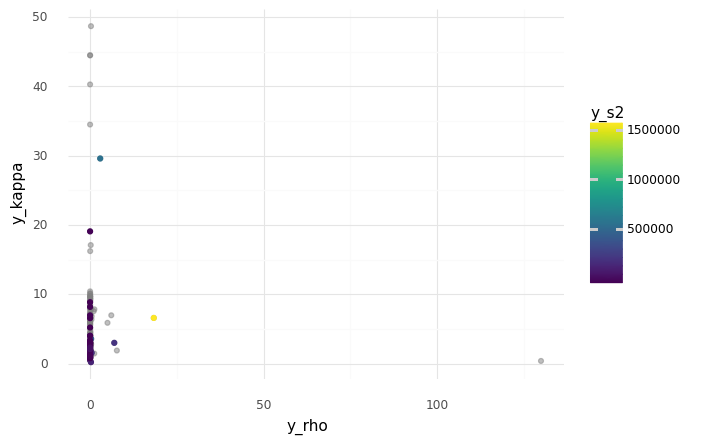

<ggplot: (8730935878431)>

In [13]:
df_pareto = (
    df_data
    >> gr.tf_mutate(pareto=gr.pareto_min(DF.y_rho, DF.y_kappa, -DF.y_s2))
    >> gr.tf_filter(DF.pareto)
)

(
    df_pareto
    >> ggplot(aes("y_rho", "y_kappa", color="y_s2"))
    + geom_point(
        data=df_data,
        alpha=1/2,
        color="grey",
    )
    + geom_point()
    
    + theme_minimal()
)


Note that the Pareto frontier is nearly vertical in the `rho, kappa` projection; we should expect to see this in a PCA of the frontier data.


### Step 2: Perform PCA on Pareto frontier

As noted in the table above, we need to perform a principal component analysis (PCA) to find $\hat{w}, \hat{b}$. First let's determine the hyperplane normal $\hat{w}$.


In [14]:
## Find principal directions
df_pca = (
    df_pareto
    >> gr.tf_pca(var=out_responses)
)
df_pca


,lam,y_rho,y_kappa,y_s2
0,1.621596e+06,0.000011,0.000006,1.000000
1,3.195812e+01,-0.054331,0.998523,-0.000005
2,7.729324e+00,-0.998523,-0.054331,0.000011


The least-variance direction (lowest `lam` value) is the direction in `rho, kappa, s2` space that exhibits least variability. This is the direction along which the data is "flattest," and hence the direction we will use as the hyperplane normal $\hat{w}$.

In [15]:
df_w = (
    df_pca
    >> gr.tf_arrange(DF.lam)
    >> gr.tf_head(1)
    >> gr.tf_select("y_rho", "y_kappa", "y_s2")
)
df_w

,y_rho,y_kappa,y_s2
0,-0.998523,-0.054331,0.000011


*Note*: There is one degree of ambiguity in the direction of $\hat{w}$; the principal directions are eigenvectors, and therefore are defined up to a scalar multiple only. Thus we could pick $\pm \hat{w}$. To resolve this ambiguity, we should pick the direction that is *aligned* with our goals. Since we aim to minimize `rho, kappa` and maximize `s2`, we can see that the direction `[-0.999, -0.054, +0.000]` is already aligned with our goals, so we need not make any further adjustment.

Next let's find the appropriate offset $\hat{b}$. We'll do this by finding the mean of the Pareto frontier data $\mu_{\text{pareto}}$ and use our chosen direction $\hat{w}$ to compute the offset from the origin to the frontier:

$$\hat{b} = \hat{w}^{\top} \mu_{\text{pareto}}$$


In [16]:
df_pareto_mean = (
    df_pareto
    >> gr.tf_summarize(
        y_rho=gr.mean(DF.y_rho),
        y_kappa=gr.mean(DF.y_kappa),
        y_s2=gr.mean(DF.y_s2),
    )
)

b_hat = float((
    df_pareto_mean
    >> gr.tf_inner(df_weights=df_w)
)["dot"][0])
b_hat


0.23456233275190985

### Step 3: Check the fitted hyperplane

Let's check the results of this computation by visualizing the fitted hyperplane against the Pareto frontier data. Most of the "action" is happening in `rho, kappa` space, so we can attempt an approximation: The hyperplane is defined by the relation $\hat{w}^{\top} [\rho, \kappa, S^2] - \hat{b} = 0$. Let's ignore variation in $S^2$ by setting $S^2 = \mathbb{E}[S^2]$, and solve for $\kappa$ to derive the equation of a line we can plot in `rho, kappa` space. Doing so yields

$$\kappa = m \rho + c$$

with $m = - \hat{w}_{\rho} / \hat{w}_{\kappa}$ and $c = - (\hat{w}_{S^2} \mathbb{E}[S^2] - \hat{b}) / \hat{w}_{\kappa}$.


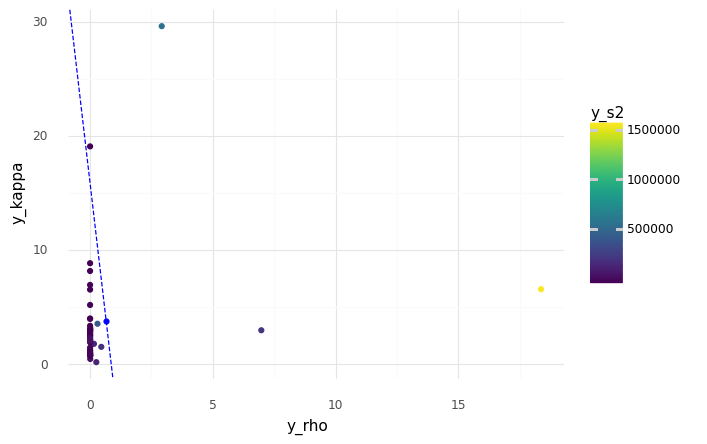

<ggplot: (8730930608577)>

In [17]:
## Compute slope and intercept
m = -float(df_w.y_rho / df_w.y_kappa)
c = -float(
    df_w.y_s2 * df_pareto_mean.y_s2
  - b_hat
) / df_w.y_kappa

## Visualize
(
    df_pareto
    >> ggplot(aes("y_rho", "y_kappa", color="y_s2"))
    + geom_point()
    ## Mean of the Pareto frontier 
    + geom_point(
        data=df_pareto_mean,
        color="blue",
    )
    ## Fitted hyperplane
    + geom_abline(
        slope=m,
        intercept=c,
        color="blue",
        linetype="dashed",
    )
    
    + theme_minimal()
)


As we expected above, the fitted hyperplane is nearly vertical. However, it is not precisely vertical. Note that there are high `s2` values that lie outside the "bulk" of low `s2` values in `rho, kappa` space; these "pull" the hyperplane to a bit of an angle. The line we see here in 2d space is only slice of the fully 3d hyperplane.


### Step 4: Compute HPI, rank candidates

Finally, we can use the $\hat{w}, \hat{b}$ values above to compute the HPI scores and rank candidates. Recall that the HPI score is defined via

$$f_{\text{HPI}}(x_i) = \frac{\hat{w}^{\top} \hat{\mu}_i - \hat{b}}{\sqrt{\hat{w}^{\top} \hat{\Sigma}_i \hat{w}}} \,\,(12)$$

The predictive mean $\hat{\mu}_i$ and covariance matrix $\hat{\Sigma}_i$ is provided by the fitted model at any selection of feature vector $x_i$. Since we're fitting each model independently, we may as well assume that the predictive covariances are independent; that the $\hat{\Sigma}_i$ are diagonal matrices. Writing out the terms for our case, we can specialize Equation (12) to

$$f_{\text{HPI, TE}} = \frac{w_{\rho} \hat{\mu}_{\rho} + w_{\kappa} \hat{\mu}_{\kappa} + w_{S^2} \hat{\mu}_{S^2} - \hat{b}}{\sqrt{w_{\rho}^2 \hat{\sigma}_{\rho}^2 + w_{\kappa}^2 \hat{\sigma}_{\kappa}^2 + w_{S^2}^2 \hat{\sigma}_{S^2}^2}}$$

The following code implements this expression:


In [18]:
df_ranked = (
    md_base
    >> gr.ev_df(df_data)
    >> gr.tf_mutate(
        num=DF.y_rho_mean * df_w.y_rho[0]
           +DF.y_kappa_mean * df_w.y_kappa[0]
           +DF.y_s2_mean * df_w.y_s2[0]
           -b_hat,
        den=gr.sqrt(
            DF.y_rho_sd**2 * df_w.y_rho[0]**2
           +DF.y_kappa_sd**2 * df_w.y_kappa[0]**2
           +DF.y_s2_sd**2 * df_w.y_s2[0]**2
        )
    )
    >> gr.tf_mutate(z_hpi=DF.num / DF.den)
    >> gr.tf_arrange(gr.desc(DF.z_hpi))
    >> gr.tf_select("z_hpi", gr.everything())
)
df_ranked


,z_hpi,y_s2,y_rho,y_kappa,x0,x1,x2,x3,x4,x5,...,x143,x144,y_kappa_mean,y_rho_sd,y_rho_mean,y_s2_mean,y_kappa_sd,y_s2_sd,num,den
0,4.546940,66203.290000,0.002920,2.18825,3.0,0.785684,0.754432,0.745954,0.745390,0.745343,...,0.018060,0.001421,2.212325,0.001085,0.002847,65670.990386,0.083785,7419.920250,0.379044,0.083362
1,4.472154,78321.619600,0.005976,2.08661,3.0,0.788113,0.756782,0.748278,0.747712,0.747665,...,0.018060,0.001385,2.137310,0.001727,0.004702,73074.747955,0.097929,9242.317098,0.464317,0.103824
2,3.294106,47136.752100,0.001139,2.55853,3.0,0.778559,0.747470,0.739068,0.738510,0.738463,...,0.018060,0.001523,2.582694,0.000397,0.001283,46121.502315,0.073705,3804.203028,0.141192,0.042862
3,2.972388,44867.712400,0.001510,2.68777,3.0,0.776237,0.745179,0.736801,0.736244,0.736198,...,0.018060,0.001557,2.604925,0.000379,0.001450,45266.329174,0.270077,3679.980919,0.130224,0.043811
4,2.190562,60806.628100,0.001872,2.29861,3.0,0.783282,0.752097,0.743645,0.743083,0.743035,...,0.018060,0.001455,2.368806,0.000562,0.001810,53936.678356,0.109216,9750.747943,0.239951,0.109539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,-6.046030,3721.000000,0.000330,6.55000,3.0,0.744466,0.692902,0.670662,0.667378,0.666728,...,0.118407,0.018570,6.535813,0.087115,0.006985,4359.532414,0.361495,1423.070588,-0.547732,0.090594
199,-6.233399,19020.271396,0.001202,40.29000,3.0,0.700143,0.623725,0.568722,0.546691,0.530771,...,0.567090,0.137865,40.578908,0.049075,0.010515,23347.047722,6.139906,8694.994566,-2.187867,0.350991
200,-6.954143,30564.479929,0.001318,34.50000,3.0,0.690109,0.614629,0.560725,0.539300,0.524020,...,0.567090,0.137987,36.698732,0.039903,0.007293,29190.377658,4.731252,7790.626065,-1.908290,0.274411
201,-7.018031,8315.616100,0.008864,2.26750,5.0,0.658677,0.612832,0.600803,0.600059,0.600001,...,0.774266,0.165128,2.342752,0.003934,0.009210,8517.289000,0.340157,3067.642886,-0.275502,0.039256


Let's do an eyeball comparison to check these z-scores:


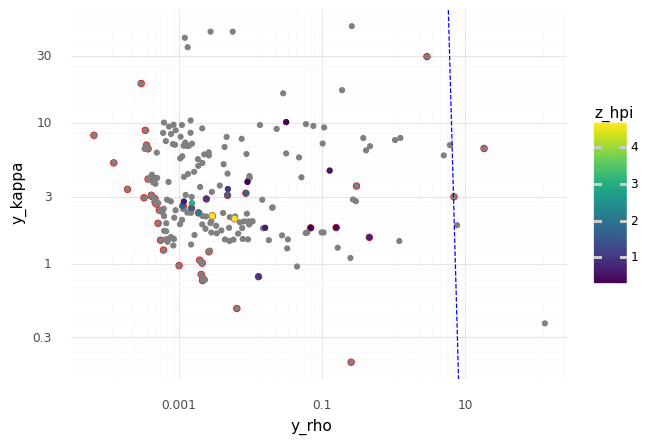

<ggplot: (8730929538350)>

In [19]:
## Visualize
(
    df_ranked
    >> gr.tf_head(20)
    >> ggplot(aes("y_rho", "y_kappa", color="z_hpi"))
    + geom_point(
        data=df_pareto,
        color="red",
        size=2,
    )
    + geom_point(
        data=df_ranked,
        color="grey",
    )
    + geom_point()
    ## Fitted hyperplane
    + geom_abline(
        slope=m,
        intercept=c,
        color="blue",
        linetype="dashed",
    )
    
    + scale_x_log10()
    + scale_y_log10()
    + theme_minimal()
)


Interestingly, all of the top-ranked candidates (as measured by HPI Z-scores) are not along the frontier within `rho, kappa` space; these must be cases where improvements in Seebeck push the candidate towards the frontier. Note also that some of the top-ranked candidates are "misfires"; those candidates that are colored (not grey) but not outlined in red are not Pareto points, but still ranked highly according to the model and acquisition function. This can be explained by the limitations of our model (see above), and the approximate nature of the HPI approach.
